In [209]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
colors =   [ '#EE8866', '#77AADD', '#AAAA00', '#EEDD88', '#FFAABB', '#99DDFF', '#44BB99', '#DDDDDD']

## Import files 

In [210]:
W = 12
days = 15
crews= 2 
CTV = 2

#define the paths to the output files
EXAMPLE = "../model/output/output_31_12_75_0_1_EWMA__2_1_0_2021_0_0_comment"
EXAMPLE2 = "../model/output/output_31_12_175_0_1_EWMA__2_1_0_2021_0_0_comment"



labels = ['EXAMPLE','EXAMPLE2']
runs = [EXAMPLE,EXAMPLE2]

numb_compared = 2




labels = labels[0:numb_compared]
start_day = 0

In [211]:
#load files 
r_sm = []
r_cm = []
h_sm = []
h_cm = []
MC_cost = []
Z = []
for output_folder in runs[0:numb_compared]:
    r_sm.append(np.load(output_folder + "/r_sm.npy"))
    r_cm.append(np.load(output_folder + "/r_cm.npy"))
    h_sm.append(np.load(output_folder + "/h_sm.npy"))
    h_cm.append(np.load(output_folder + "/h_cm.npy"))
    MC_cost.append(np.load(output_folder + "/MC.npy"))
    Z.append(np.load(output_folder + "/Z.npy"))
   


In [212]:
#import data for year
data = pd.read_csv('../model/data/weather/2021_data.csv',index_col=0)[start_day*24:]
data['rev'] = (data['price[EUR/MWh]']*data['power[MW]'])
rev_ls = data['rev'].to_numpy()
rev = (rev_ls.repeat(4)/4)[0:len(r_sm[0])]
#cap revenue at 0 since turbines always have the option to shut down
rev = np.maximum(rev,0)


#define WHL and WSL
swh = data['swh']
swh = (swh>1.8).astype(int) 
swh = swh.repeat(4)[0:len(r_sm[0])]
data_wind_limit = data['wind_speed']>20
data_wind_limit = data_wind_limit.repeat(4)[0:len(r_sm[0])]
limit = swh | data_wind_limit 

## Plot maintenance 

Text(0, 0.5, 'Remaining SM & CM [h]')

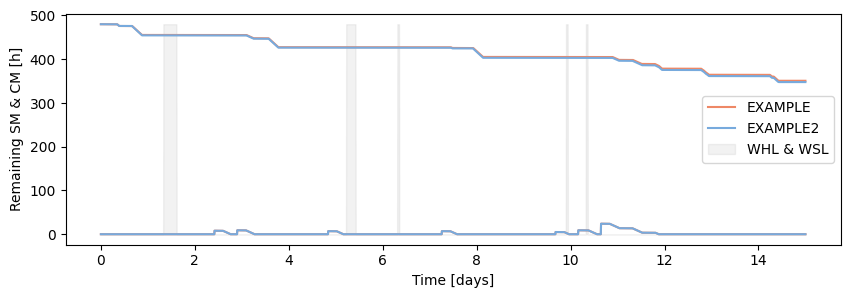

In [213]:
plt.figure(figsize=(10,3))

for forecast in range(0,numb_compared): 
    x = np.linspace(start_day,days,len(r_sm[forecast]))
    plt.plot(x,h_sm[forecast].sum(axis=1)/4, label=str(labels[forecast]),color = colors[forecast])  
    plt.plot(x,h_cm[forecast].sum(axis=1)/4,color = colors[forecast])

plt.fill_between(x,0,limit*np.max(h_sm[forecast].sum(axis=1)/4),color='grey',alpha=0.1,label='WHL & WSL')

plt.legend()
plt.xlabel('Time [days]')
plt.ylabel('Remaining SM & CM [h]')

#plt.savefig('timeline.png',bbox_inches='tight',dpi=600)

## Financial metrics

In [214]:
#calcuate financial metrics
ideal_rev = []
revenue = []
lost_revenue_sm = [] 
lost_revenue_with_cat = []
for forecast in range(0,numb_compared):
    #Here wether turbines have CM remaining or if SM is performed is used as turbines being shut down. 
    #the model does provide the X variable indicating whether a turbine is running, however if forecasting negative revenue,
    #it will just shut it down no matter the actual reveue. There CM and SM is used. 
    ideal  = np.ones((W,len(r_sm[forecast]))).sum(axis= 0)
    down =   r_sm[forecast].sum(axis=1)  
    down_cat = r_cm[forecast].sum(axis=1) 
    h_cat_bin = h_cm[forecast].copy()
    h_cat_bin[h_cat_bin>0.5]  = 1 
    down_cat_toal =  h_cat_bin.sum(axis=1)
    down_total = down + down_cat_toal

    revenue.append( (ideal-down_total)*rev)
    lost_revenue_sm.append( down*rev)
    lost_revenue_with_cat.append( down_total*rev)
    ideal_rev.append(ideal*rev)

## Plots

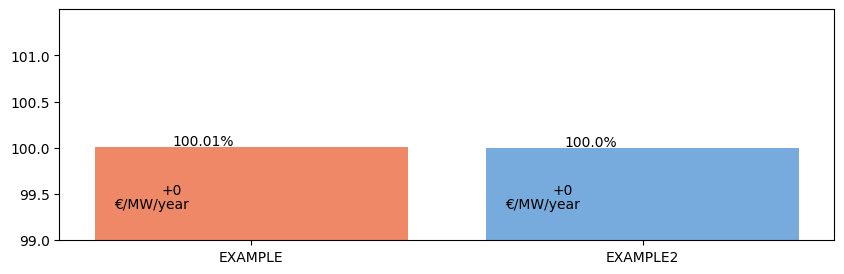

In [215]:
#total profit plot
plt.figure(figsize=(10,3))
total_profit = []
for i in range(0,numb_compared):
    total_profit.append(np.sum(revenue[i])-MC_cost[i].sum())
total_profit_pct = (total_profit/np.min(total_profit))*100
total_profit_diff = total_profit-np.min(total_profit)

plt.bar(labels,total_profit_pct, label = labels,color = colors[0:numb_compared])
plt.ylim((99,101.5))
plt.yticks(np.linspace(99,101,5))
for i in range(0,numb_compared):
    plt.text(i-0.2, total_profit_pct[i]*1.0002, str(np.round(total_profit_pct[i],2))+"%") 

for i in range(0,numb_compared):
    plt.text(i-0.23, 99.5, '+'+str(int(total_profit_diff[i]/288))+"") 
    plt.text(i-0.35, 99.35, "€/MW/year") 

#plt.savefig("figures/forecast_total_profit_2022_V3.eps",bbox_inches='tight')
#plt.savefig("figures/forecast_total_profit_2022.png",bbox_inches='tight')

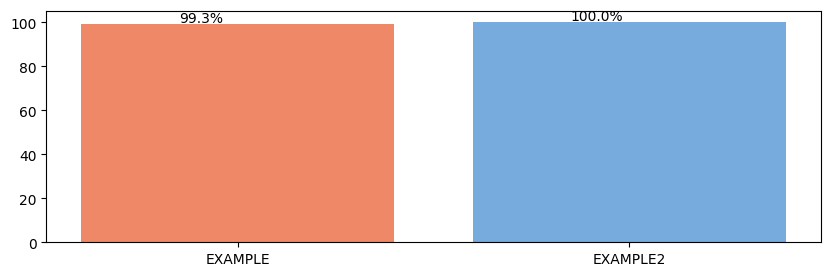

In [216]:
#lost revenue due to SM
lost_revenue_percent = [] 
for i in range(0,numb_compared):
    lost_revenue_percent.append(np.sum(lost_revenue_sm[i]))
lost_revenue_percent = lost_revenue_percent/np.max(lost_revenue_percent)*100
plt.figure(figsize=(10,3))
plt.bar(labels,lost_revenue_percent,label = labels,color = colors[0:numb_compared])
#plt.legend(loc = 'lower left')
#plt.title("Lost revenue due to scheduled maintenance - 2022")
for i in range(0,numb_compared):
    plt.text(i-0.15, lost_revenue_percent[i]+1, str(np.round(lost_revenue_percent[i],1))+"%")

#plt.savefig("figures/forecast_lost_revenue_2022_V3.eps",bbox_inches='tight')
#plt.savefig("figures/forecast_lost_revenue_2022_V3.png",bbox_inches='tight')


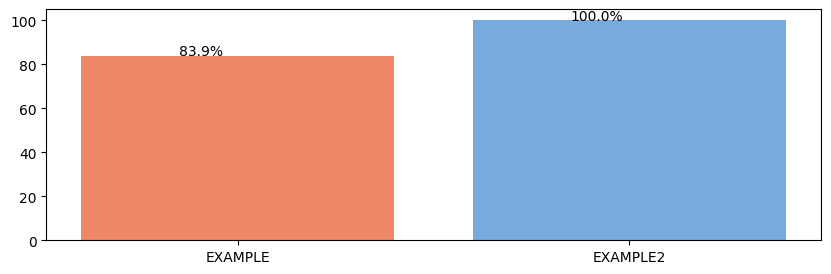

In [217]:
#fuel consumtion plot
plt.figure(figsize=(10,3))
MC_cost_percent = []
for i in range(0,numb_compared):
    MC_cost_percent.append(MC_cost[i].sum())
MC_cost_percent = MC_cost_percent/np.max(MC_cost_percent)*100
plt.bar(labels,MC_cost_percent,label = labels,color = colors[0:numb_compared])
for i in range(0,numb_compared):
    plt.text(i-0.15, MC_cost_percent[i]+0.1, str(np.round(MC_cost_percent[i],1))+"%")
    
#plt.savefig("figures/forecast_MC_cost_2022_V3.eps",bbox_inches='tight')
#plt.savefig("figures/forecast_MC_cost_2022.png",bbox_inches='tight')

## CTV Location

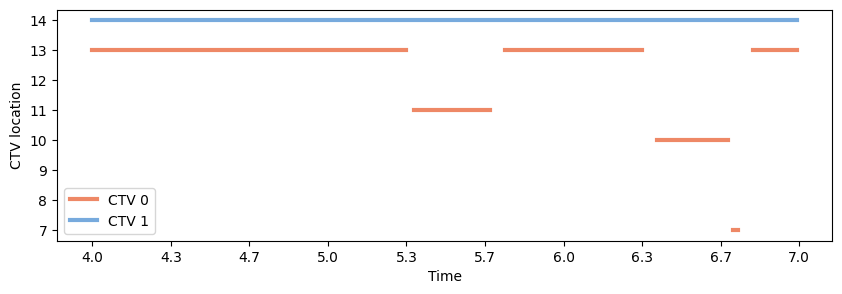

In [218]:
#plot CTV location 
day = 4
days_to_plot = 3
method  = 1
CTV=2


plt.figure(figsize=(10,3))
length =day*96+days_to_plot*96 - day*96
for i in range(CTV):
    pos = np.argmax(np.concatenate((np.zeros((length,1)),Z[method][i][day*96:day*96+days_to_plot*96]),axis=1),axis=1)
    #if zero then nan
    pos = np.where(pos==0,np.nan,pos)
    plt.plot(pos,label = 'CTV '+str(i),color = colors[i],linewidth=3)
xticks = np.linspace(0,days_to_plot*96,10)
xticklabels = np.round(np.linspace(day,day+days_to_plot,10),1)
plt.xticks(xticks,xticklabels)
plt.ylabel('CTV location') 
plt.xlabel('Time')
plt.legend()


## Case study

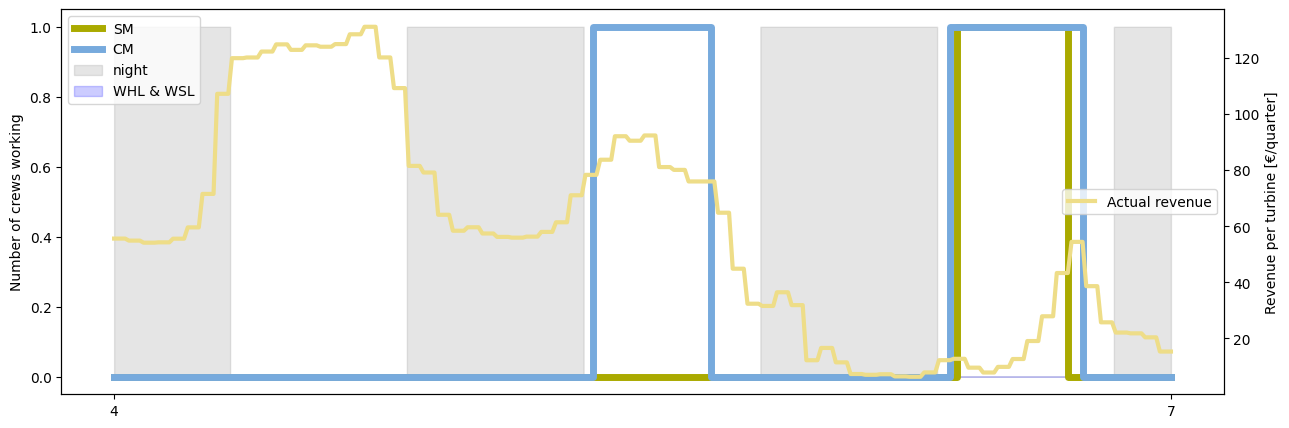

In [219]:
method = 1
day = 4
days_to_plot  = 3
swh_ = swh[day*24*4:(day+days)*24*4]


fig, axs = plt.subplots(figsize=(15,5))


night = np.ones(days_to_plot*24*4)
for i in range(days_to_plot):
    night[i*24*4+8*4:20*4+i*24*4] = 0

x = np.linspace(day,day+days_to_plot,num=days_to_plot*24*4)
axs.step(x,r_sm[method][day*24*4:(day+days_to_plot)*24*4,:].sum(axis=1),label="SM",color = colors[2],linewidth=5)
axs.step(x,r_cm[method][day*24*4:(day+days_to_plot)*24*4,:].sum(axis=1),label="CM",color = colors[1],linewidth=5)
axs.fill_between(x,0,night,alpha=0.2,step='mid',label="night",color = 'grey')
axs.fill_between(x,0,limit[day*24*4:(day+days_to_plot)*24*4]*crews,alpha=0.2,step='mid',label="WHL & WSL",color = 'blue')
axs.set_ylabel("Number of crews working")

axs2 = axs.twinx()
axs2.plot(x,rev[day*24*4:(day+days_to_plot)*24*4],label="Actual revenue",color=colors[3],linewidth = 3)


axs.set_xticks([day,day+days_to_plot])
axs2.set_ylabel("Revenue per turbine [€/quarter]")
axs.legend(loc='upper left')
axs2.legend(loc='center right')

#plt.savefig("figures/case_studies/ANN_99.png",bbox_inches='tight')
#plt.savefig("figures/case_studies/ANN_99.eps",bbox_inches='tight')
